In [31]:
import pandas as pd
review = pd.read_json('tokenized.json')

unused = ['user_id', 'release_date', 'helpful', 'unixReviewTime', 'reviewTime']
review.head()

,user_id,is_spoiler,rating_x,tokenized,duration,genre,release_date
0,ur81689327,True,9,"[awesom, classic, thi, movi, one, favorit, tim...",2,"[Crime, Drama]",1994
1,ur70090039,True,10,"[movi, lover, miss, second, protagonist, thi, ...",2,"[Crime, Drama]",1994
2,ur79297787,True,9,"[protagonist, protagonist, film, get, movi, li...",2,"[Crime, Drama]",1994
3,ur79209549,True,10,"[veri, nice, excel, movi, watch, twice, thrice...",2,"[Crime, Drama]",1994
4,ur20574753,True,10,"[worthi, number, one, spot, one, best, movi, d...",2,"[Crime, Drama]",1994


# Embeddings

In [32]:
from gensim.models import Word2Vec

tokenized_sentences = list(review['tokenized'])
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
#model.save('word2vec_model.model')
#loaded_model = Word2Vec.load('word2vec_model.model')

In [33]:
from tqdm import tqdm

tqdm.pandas()
review['vec'] = review['tokenized'].apply(lambda x: [model.wv[wd] for wd in x])

review['vec'] = review['vec'].progress_apply(lambda x: [sum(i) for i in zip(*x)])
review.head()

100%|██████████| 45103/45103 [01:36<00:00, 468.10it/s]


,user_id,is_spoiler,rating_x,tokenized,duration,genre,release_date,vec
0,ur81689327,True,9,"[awesom, classic, thi, movi, one, favorit, tim...",2,"[Crime, Drama]",1994,"[23.490239452570677, 27.68424529954791, 9.5201..."
1,ur70090039,True,10,"[movi, lover, miss, second, protagonist, thi, ...",2,"[Crime, Drama]",1994,"[19.714689899235964, 24.551260635256767, 6.728..."
2,ur79297787,True,9,"[protagonist, protagonist, film, get, movi, li...",2,"[Crime, Drama]",1994,"[54.36877682432532, 43.295619778335094, 38.349..."
3,ur79209549,True,10,"[veri, nice, excel, movi, watch, twice, thrice...",2,"[Crime, Drama]",1994,"[5.6426764863717835, 49.042090721428394, 5.214..."
4,ur20574753,True,10,"[worthi, number, one, spot, one, best, movi, d...",2,"[Crime, Drama]",1994,"[20.33705595158972, 24.813312392681837, 1.0416..."


In [35]:
unused_columns = ['user_id','tokenized','duration','release_date','rating_x','genre']
reviewed = review.drop(columns=unused_columns)
review_split = pd.DataFrame(review['vec'].apply(pd.Series))
reviewed = pd.concat([review['is_spoiler'], review_split], axis=1)
reviewed.head()


,is_spoiler,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,True,23.490239,27.684245,9.520114,33.018080,-17.915115,10.143909,7.846983,-40.326109,5.659602,...,-2.331416,-8.742300,-4.354354,0.963261,-28.675904,-6.066828,3.491306,24.259282,-20.041075,22.176552
1,True,19.714690,24.551261,6.728383,62.570559,-5.105829,-5.758247,-5.841912,-49.529002,1.343360,...,-3.479219,-18.669890,16.310429,23.348899,-36.185733,14.192708,24.428578,22.943300,-34.133023,13.990741
2,True,54.368777,43.295620,38.349316,107.386653,-37.149726,24.555224,-2.732785,-83.083928,3.288395,...,-9.581870,-18.840444,7.857593,56.979377,-79.147692,39.259551,14.892746,75.641260,-49.710833,44.679384
3,True,5.642676,49.042091,5.214045,54.877492,-20.123575,10.474341,-14.677159,-42.380999,21.884580,...,-15.419011,1.061943,-14.097928,15.021182,-34.460947,23.802343,18.479465,29.462868,-38.936286,33.803183
4,True,20.337056,24.813312,1.041694,45.290827,-29.471596,18.725821,7.358865,-41.647442,22.966515,...,2.672830,-2.627148,-6.545622,23.647613,-37.266562,12.647250,9.977034,18.761324,-28.410151,26.673031


In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

def report(y_real, y_pred):
    
    cm = confusion_matrix(y_real, y_pred)


    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["0", "1"],
                yticklabels=["0", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    confusion_statistics(cm)

def confusion_statistics(cm):
    accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    false_positive_rate = cm[0][1] / (cm[0][1] + cm[0][0])
    false_negative_rate = cm[1][0] / (cm[1][0] + cm[1][1])
    recall_rate = cm[1][1] / (cm[1][1] + cm[1][0])
    precision_rate = cm[1][1] / (cm[1][1] + cm[0][1])

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision_rate:.2f}')
    print(f'Recall: {recall_rate:.2f}')
    print(f'False positive rate: {false_positive_rate:.2f}')
    print(f'False negative rate: {false_negative_rate:.2f}')


In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(review_split, review['is_spoiler'], test_size=0.2)

In [37]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)


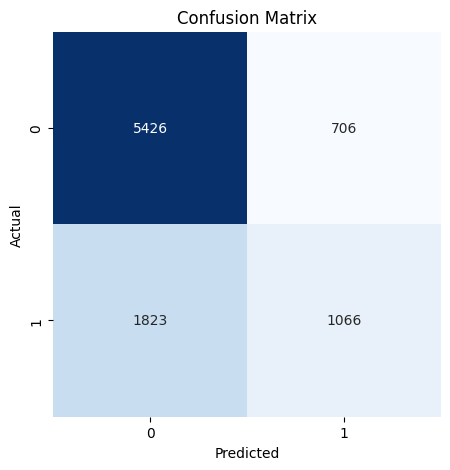

Accuracy: 0.72
Precision: 0.60
Recall: 0.37
False positive rate: 0.12
False negative rate: 0.63


In [51]:
report(y_test,y_pred)


In [47]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy scores
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)



Training Accuracy: 1.0
Test Accuracy: 0.7276355171267044


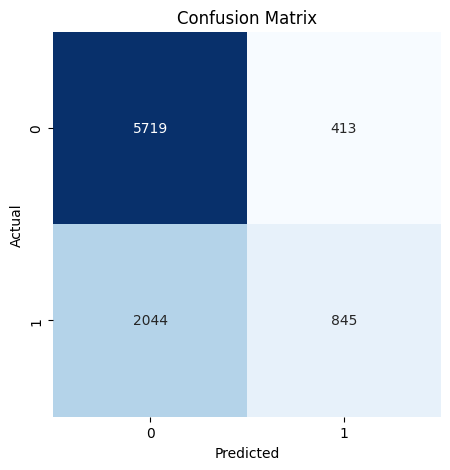

Accuracy: 0.73
Precision: 0.67
Recall: 0.29
False positive rate: 0.07
False negative rate: 0.71


In [50]:
report(y_test,y_test_pred)

In [3]:
reviews = pd.read_json('IMDB_reviews.json',lines=True)